**Note: Once you [download `clothing-dataset-small` directory](https://github.com/alexeygrigorev/clothing-dataset-small) you have to fix some paths down there. ;)**

In [ ]:
!pip install catboost scikit-learn hyperopt venn-abers mapie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix, eval_metric

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from hyperopt import hp, fmin, tpe, STATUS_OK

import math, subprocess
from collections import Counter

from tensorflow.keras.preprocessing.image import load_img

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

from venn_abers import VennAbersCalibrator

2024-02-14 20:57:27.873284: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
RANDOM_SEED = 42

# Loading the dataset / Checking statistics

In [3]:
df = pd.read_csv('./data/combined-features.csv')
df.head()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,...,vgg19_504,vgg19_505,vgg19_506,vgg19_507,vgg19_508,vgg19_509,vgg19_510,vgg19_511,file_id,label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,...,0.116475,3.400921,3.611810,0.831427,1.011819,0.470787,0.933962,0.000000,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0
1,0.047840,0.264508,0.390923,0.142860,0.129282,0.150060,0.069824,0.481221,0.330697,0.258998,...,10.499381,2.195004,18.171705,1.706563,0.722449,0.958704,5.522590,0.298218,dress/041c6bde-e737-46fd-9586-984c1503941f.jpg,0
2,0.942071,0.434878,0.697832,0.251812,0.220720,0.003102,0.142887,0.486080,0.071632,0.570452,...,0.823151,2.738157,3.098589,12.312897,2.469384,0.712025,1.020714,1.618408,dress/04f0b07f-4b9f-4c55-bc5d-b693658fb32c.jpg,0
3,0.279040,0.390771,0.115167,0.213695,0.314327,0.105088,0.064898,0.193854,0.482503,0.612311,...,1.585208,1.675288,6.131248,0.140504,10.127681,0.611325,2.268990,0.110608,dress/053689bb-5928-489b-aeaf-dfb969b05e93.jpg,0
4,0.567760,0.119651,0.390262,0.429970,0.153197,0.227783,0.506306,0.387863,0.170855,0.258183,...,3.026077,14.017796,0.781647,0.939281,1.200090,1.347519,0.297584,0.198936,dress/0546d34a-a369-4723-8d3a-74c0f51af26c.jpg,0


In [4]:
df.describe()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,...,vgg19_503,vgg19_504,vgg19_505,vgg19_506,vgg19_507,vgg19_508,vgg19_509,vgg19_510,vgg19_511,label
count,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,...,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000,3781.000000
mean,0.195795,0.300117,0.189320,0.373138,0.277161,0.206194,0.304091,0.358084,0.480431,0.814448,...,2.649786,2.138089,2.980282,2.988209,1.117379,1.484800,0.893433,1.686215,0.399788,5.030680
std,0.231095,0.223786,0.194411,0.244870,0.200353,0.203023,0.290530,0.395895,0.371558,0.627137,...,2.279353,2.286377,3.584282,4.295325,1.321210,1.595631,1.252462,1.509246,0.854213,2.986054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000505,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.047268,0.126674,0.049479,0.182173,0.134602,0.060524,0.082537,0.120403,0.216359,0.294005,...,0.998765,0.628951,0.659573,0.407576,0.247565,0.361829,0.165624,0.631946,0.000000,2.000000
50%,0.118978,0.245435,0.125429,0.336051,0.231775,0.142883,0.210777,0.242635,0.391344,0.702467,...,2.141851,1.413955,1.811591,1.488661,0.686509,0.972161,0.512690,1.233251,0.093254,5.000000
75%,0.258900,0.424694,0.260189,0.510952,0.369858,0.286645,0.448716,0.446897,0.648064,1.229507,...,3.579922,2.778015,3.950869,3.659759,1.474986,2.050608,1.150597,2.256328,0.409186,8.000000
max,2.715662,1.429803,1.637657,1.936424,1.793500,1.638168,2.140471,4.355899,3.465032,3.906877,...,26.078701,21.292980,34.794262,46.250000,12.312897,12.370987,18.568586,12.539578,15.235866,9.000000


In [5]:
features_max_values = pd.DataFrame(df.iloc[:, :-2].max()).sort_values(by=0, ascending = False)
features_max_values.head()

,0
vgg19_83,99.465200
vgg19_377,71.284510
vgg19_345,62.724910
vgg19_487,59.990475
vgg19_363,56.840580


In [6]:
features_max_values.tail()

,0
xc_1760,0.385500
xc_1657,0.372906
xc_254,0.367293
xc_2018,0.331271
xc_1567,0.312353


Maybe it might be helpful to try and scale features after splitting the dataset in case of training algos that are not tree-based.

In [9]:
df.shape

(3781, 4610)

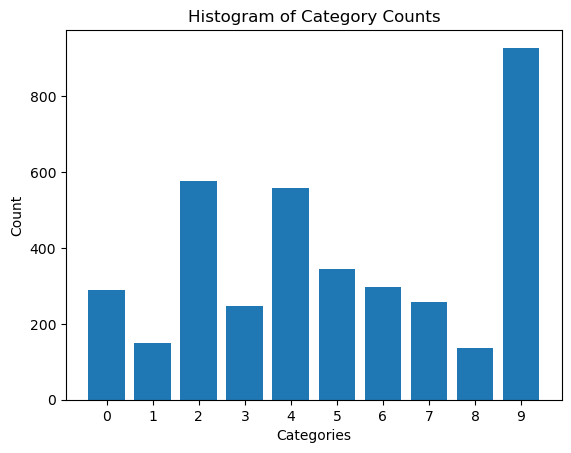

In [10]:
labels_frequency = df['label'].value_counts()
plt.bar(labels_frequency.index, labels_frequency.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks([9, 2, 4, 5, 6, 0, 7, 3, 1, 8])
plt.title('Histogram of Category Counts')
plt.show();

# Splitting the data 

## Calibration 

In [192]:
# Calibration set for VensABERS
X_full, X_calib_va, y_full, y_calib_va = train_test_split(df, df['label'], test_size=500, random_state=RANDOM_SEED, stratify=df['label'])
y_calib_va.shape[0], y_full.shape[0]

(500, 3281)

In [193]:
# Calibration set for APS (Adaptive Prediction Sets)
X_full, X_calib_aps, y_full, y_calib_aps = train_test_split(X_full, y_full, test_size=500, random_state=RANDOM_SEED, stratify=y_full)
y_calib_aps.shape[0], y_full.shape[0]

(500, 2781)

## Train/Validation/Test (for training a classifier)

In [194]:
#Defining train/valid/test split
X_full, X_test, y_full, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.25, random_state=42, stratify = y_full)

In [195]:
y_train.shape[0], y_test.shape[0], y_valid.shape[0]

(1668, 557, 556)

### Dropping columns / Reseting indexes

In [196]:
X_full = X_full.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_train = X_train.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_valid = X_valid.drop(['file_id', 'label'], axis=1).reset_index(drop=True)

#Will come in handy when we try to visualize prediction sets
X_test_full = X_test.reset_index(drop=True)
X_test_full = X_test_full[['file_id', 'label']] #To save some RAM ;)

X_test = X_test.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_calib_va = X_calib_va.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_calib_aps = X_calib_aps.drop(['file_id', 'label'], axis=1).reset_index(drop=True)

In [197]:
y_full = y_full.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_calib_va = y_calib_va.reset_index(drop=True)
y_calib_aps = y_calib_aps.reset_index(drop=True)

### Checking if `X_test_full` is same as `X_test` whilst excluding last two columns

In [11]:
X_test_full.shape, len(X_test.columns), len(X_test_full.iloc[:, :-2].columns), (X_test_full.iloc[:, :-2].head(1) == X_test.head(1)).sum().sum()

((557, 4610), 4608, 4608, 4608)

You don't need to perform label encoding separately when using CatBoost.

## Scaling data using `StandardScaler`

Any tree-based model is scale-invariant so this is done just for the sake of POC. 

In [198]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_calib_va_scaled = scaler.transform(X_calib_va)
X_calib_aps_scaled = scaler.transform(X_calib_aps)

# `CatBoostClassifier` (Training + Hyperparameter Tuning)

### Defining `Pool` objects

In [199]:
#Defining Pools

#----------TRAINING
train_pool = Pool(
    data = X_train,
    label = y_train,
)

train_scaled_pool = Pool(
    data = X_train_scaled,
    label = y_train,
)

#---------VALIDATION

validation_pool = Pool(
    data = X_valid,
    label = y_valid,
)

validation_scaled_pool = Pool(
    data = X_valid_scaled,
    label = y_valid,
)
#---------TEST
test_pool = Pool(
    data = X_test,
    label = y_test,
)

test_scaled_pool = Pool(
    data = X_test_scaled,
    label = y_test,
)

### *Vanilla* model (without `StandardScaler` + out-of-the-box)

In [103]:
cls = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

cls.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.110732
0:	learn: 0.6037170	test: 0.5989209	best: 0.5989209 (0)	total: 186ms	remaining: 3m 6s
200:	learn: 0.9976019	test: 0.9172662	best: 0.9208633 (185)	total: 31.9s	remaining: 2m 6s
bestTest = 0.9208633094
bestIteration = 185
Shrink model to first 186 iterations.


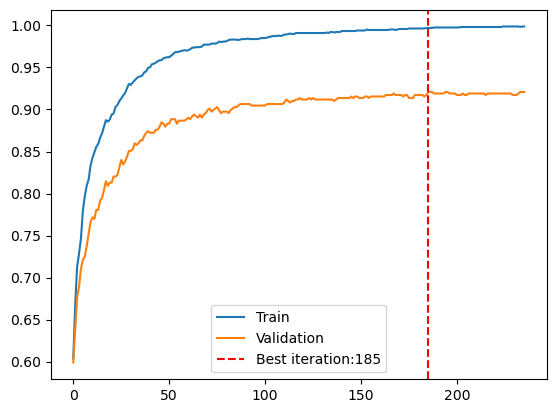

In [104]:
best_iteration = cls.best_iteration_
plt.plot(cls.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(cls.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

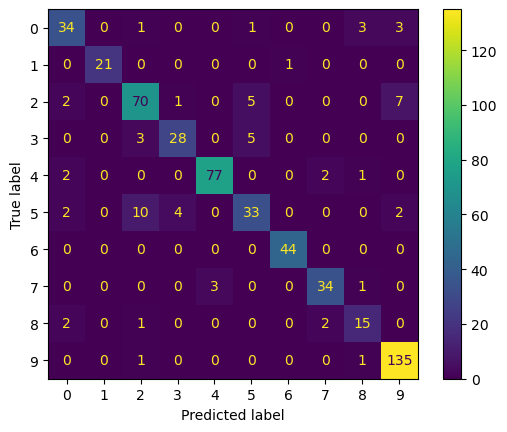

In [109]:
cm = get_confusion_matrix(cls, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=cls.classes_)
disp.plot();

In [110]:
cls.best_score_

{'learn': {'Accuracy': 0.9988009592326139, 'MultiClass': 0.0874642022222066},
 'validation': {'Accuracy': 0.920863309352518,
  'MultiClass': 0.30667147190450766}}

### *Vanilla* model (with `StandardScaler` + out-of-the-box)

In [111]:
cls_scaled = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

cls_scaled.fit(train_scaled_pool,
          eval_set=validation_scaled_pool,
          verbose=200)

Learning rate set to 0.110732
0:	learn: 0.6037170	test: 0.5989209	best: 0.5989209 (0)	total: 176ms	remaining: 2m 56s
200:	learn: 0.9976019	test: 0.9172662	best: 0.9208633 (185)	total: 31.9s	remaining: 2m 6s
bestTest = 0.9208633094
bestIteration = 185
Shrink model to first 186 iterations.


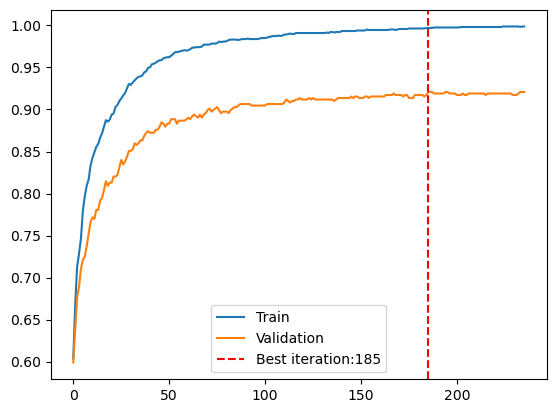

In [112]:
best_iteration = cls_scaled.best_iteration_
plt.plot(cls_scaled.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(cls_scaled.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

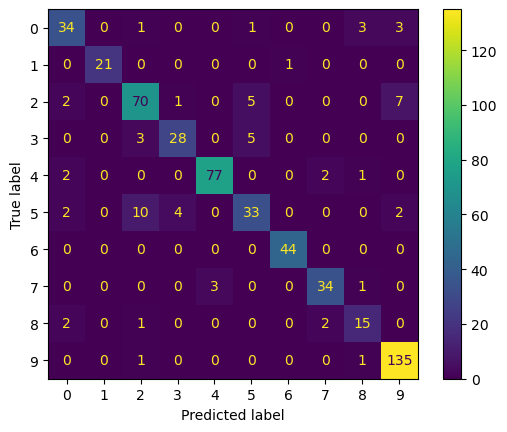

In [117]:
cm = get_confusion_matrix(cls_scaled, test_scaled_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=cls_scaled.classes_)
disp.plot();

In [116]:
cls_scaled.best_score_

{'learn': {'Accuracy': 0.9988009592326139, 'MultiClass': 0.0874642022222066},
 'validation': {'Accuracy': 0.920863309352518,
  'MultiClass': 0.30667147190450766}}

Same result, as expected. ;)

### Tuning the model using `hyperopt`

In [132]:
def hyperopt_objective(params):
    print(params)
    model = CatBoostClassifier(**params,
                               task_type = 'GPU',
                               loss_function = 'MultiClass',
                               eval_metric = 'MultiClass',
                               early_stopping_rounds=50,
                               random_seed = RANDOM_SEED)
    
    model.fit(train_pool, verbose=0, eval_set=validation_pool)
    
    y_valid = validation_pool.get_label()
    y_pred = model.predict_proba(validation_pool)
    return {'loss': -eval_metric(y_valid, y_pred, 'Accuracy')[0], 'status': STATUS_OK}

space = {
    'learning_rate': hp.loguniform('learning_rate', math.log(0.01), math.log(0.3)), 
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', math.log(1), math.log(10))
}

In [133]:
#Uncomment this if you want to do hyperoptimization
# best = fmin(hyperopt_objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10,
#             rstate=np.random.default_rng(RANDOM_SEED))

{'depth': 6, 'l2_leaf_reg': 4.169836222804728, 'learning_rate': 0.15917237508778656}
{'depth': 9, 'l2_leaf_reg': 4.057412493793687, 'learning_rate': 0.02778169688135642}
{'depth': 4, 'l2_leaf_reg': 1.1848435957142298, 'learning_rate': 0.016484730699711236}
{'depth': 7, 'l2_leaf_reg': 1.6301107708185072, 'learning_rate': 0.03948467602347645}
{'depth': 3, 'l2_leaf_reg': 1.2492364447258786, 'learning_rate': 0.055315879907674566}
{'depth': 7, 'l2_leaf_reg': 1.4488522802077135, 'learning_rate': 0.13026382468216652}
{'depth': 4, 'l2_leaf_reg': 9.930868012926428, 'learning_rate': 0.10780126348054113}
{'depth': 3, 'l2_leaf_reg': 6.7622252396425955, 'learning_rate': 0.01244398537983132}
{'depth': 4, 'l2_leaf_reg': 5.907188337611997, 'learning_rate': 0.11705755415853294}
{'depth': 8, 'l2_leaf_reg': 3.023828588476758, 'learning_rate': 0.030207324138548857}
100%|██████████| 10/10 [41:17<00:00, 247.77s/trial, best loss: -0.935251798561151]


In [138]:
best_params = {'depth': 7,
               'l2_leaf_reg': 1.4488522802077135,
               'learning_rate': 0.13026382468216652}

### Model + `best_params`

According to defined `hyperopt_objective` where `eval_metric='MultiClass'` and `early_stopping_rounds=50` we should gain best `Accuracy` score of (`0.935251798561151`) if we set our model to have same `eval_metric='MultiClass'` and let it do default of 1000 iterations and we should slightly overfit towards the end which is why we are using `early_stopping_rounds = 50` again. 

Namely, `hyperopt_objective` is optimized to detect overfiting for `eval_metric='MultiClass'`.

In [200]:
best_params = {'depth': 7,
               'l2_leaf_reg': 1.4488522802077135,
               'learning_rate': 0.13026382468216652}

cls = CatBoostClassifier(**best_params,
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'MultiClass',
                    custom_loss='Accuracy',
                    early_stopping_rounds = 50
                    )


cls.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

0:	learn: 1.8952872	test: 1.8913702	best: 1.8913702 (0)	total: 330ms	remaining: 5m 29s
200:	learn: 0.0366018	test: 0.2900432	best: 0.2900432 (200)	total: 57.7s	remaining: 3m 49s
400:	learn: 0.0124607	test: 0.2404820	best: 0.2404820 (400)	total: 1m 51s	remaining: 2m 47s
600:	learn: 0.0067726	test: 0.2256602	best: 0.2256602 (600)	total: 2m 46s	remaining: 1m 50s
800:	learn: 0.0045091	test: 0.2184042	best: 0.2182532 (797)	total: 3m 40s	remaining: 54.8s
999:	learn: 0.0033443	test: 0.2127833	best: 0.2127582 (998)	total: 4m 34s	remaining: 0us
bestTest = 0.2127581672
bestIteration = 998
Shrink model to first 999 iterations.


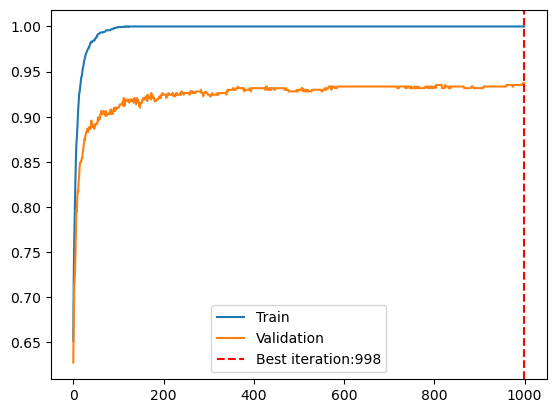

In [201]:
best_iteration = cls.best_iteration_
plt.plot(cls.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(cls.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

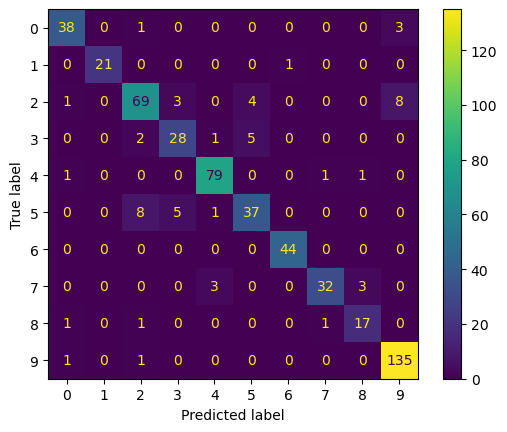

In [202]:
cm = get_confusion_matrix(cls, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=cls.classes_)
disp.plot();

In [203]:
#Final accuracy
max(cls.get_evals_result()['validation']['Accuracy'])

0.9370503597122302

# Conformal Prediction using `MAPIE` and `venn-abers`

**Acknowledgment:**
Before proceeding, I must acknowledge that all these explanations lack scientific rigor, and you should seek such rigor elsewhere. Much of this is merely a practitioner's point of view, driven by my desire to comprehend what lies beneath the surface before blindly applying certain libraries. This approach has aided me in understanding approximately 20% of what is crucial to know (following the 80/20 principle). If you have studied proof-based math or taken a similar course and appreciate that level of rigor, please refer to the original papers, especially [this GitHub resource](https://github.com/valeman/awesome-conformal-prediction), which is truly awesome. Leave us practitioners to our methods. It will take some time before we find enjoyment in Bloch's or Velleman's books.

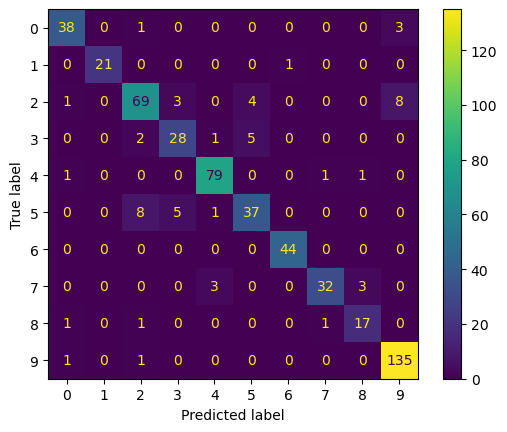

In [204]:
cm = get_confusion_matrix(cls, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=cls.classes_)
disp.plot();

According to confusion matrix obtained by the *best* model, overall there should be no problem in predicting any class. There are relatively few False Positives, but we assume that the model is uncalibrated in terms of it's scores and as such they can't represent true probabilities. A simple intuitive example is weather forecasting, and in particular probability of raining at a particular day. e.g. For days that forecaster said that there was 70% of probability of raining, than out of all those days if it rained ~70% of time his probability of `p(raining)=0.70` is well-calibrated. If, theoretically speaking, for each given probability we ensure nearly the same percentage of days raining then we can say that whole forecaster's model is well-calibrated. 


**NOTE: Numerous papers have been written to demonstrate that scores from your favorite models are not well-calibrated, even Logistic Regression, which is typically appended as a final model before predicting probabilities for competitions on Kaggle. What Logistic Regression essentially does to your model's probabilitiesis something similar to "Platt Scaling." It corrects the model to some extent due to its nature, and when examining reliability diagrams, Logistic Regression is closest to the diagonal. However, it requires assumptions that are not always met. Therefore, instead of struggling with Logistic Regression to calibrate those probabilities, consider submitting a submission using the Conformal Prediction framework next time. Nevertheless, if we begin with the assumption that *no model is ever calibrated*, we can't trust any `predict_proba` entirely, and thus, they don't represent TRUE probabilities but merely "proxies."**

In [205]:
proba = cls.predict_proba(X_test)

In [206]:
class_indices = {'dress': 0,
                 'hat': 1,
                 'longsleeve': 2,
                 'outwear': 3,
                 'pants': 4,
                 'shirt': 5,
                 'shoes': 6,
                 'shorts': 7,
                 'skirt': 8,
                 't-shirt': 9}

## Model + `MapieClassifier(method="score")`

This is the "Hello World" version of Conformal Prediction for multi-class problems. We use calibration dataset to calculate `1-alpha` quantile of distribution of non-conformity scores. The calibration dataset should be looked as a collection of (true_label, predicted_proba_from_model). Since we are dealing with multi-class problem then `predicted_proba_from_model` is `softmax` score. For each instance of calibration dataset you find the ground truth and calculate non-conformity score such that `f(x)` in `1-f(x)` represents part of the `softmax` score which belongs to ground truth. 

Here is an example for three-class classification in form of pseudo-code:
```
non_conformity_scores = []

ground_truth = 'class_2'

softmax_score = [0.2, 0.3, 0.5]

index_of_ground_truth = 1

non_conformity_score = 1 - softmax_score[1]

non_conformity_scores.append(non_conformity_score)

```

Why is there `1` in `1-softmax_score[1]`? The `1-softmax_score[1]` is just a measure of "disimilarity"/"strangeness"/"non-conformity" between ground truth for any given class and it's predicted "probability". 
 

Say for example that on `class_1` you capture the part of softmax score for that class to be `0.3`. The ground truth should be `probability = 1` for any given class. How far are you from ground truth? `0.7`. Very far. So, that particular instance is "not conforming" well and "the model is not certain about it". Conversely, if the value is close to 1 then obviously that instance is well-conforming to that particular class and the model is very certain of it. 


You calculate that non-conformity measure for each instance in calibration dataset and you get a distribution of non-conformity scores. You then order those scores from conforming (certain) to non-conforming (uncertain) ones (basically, from smaller to largest) and calculate the `(1-alpha)` quantile of that distribution. That will serve as "threshold" for "binary decision" if the new (test) point 'conforms' or doesn't conform (if you should include the class in the prediction set for particular test point or not). So, given a new instance from test set the model predicts softmax score for it. Now instead of finding part of softmax for a particular class you calculate non-conformity score for each part of it, and based on the `(1-alpha)` threshold (value of non-conformity score at `(1-alpha)` quantile) you include the class in the final prediction set if it is on the left side of our `(1-alpha)` quantile. In that case you measure "given this particular test instance, what classes are conforming?". The Conformal Prediction guarantees you that in each such prediction set there is at least `(1-alpha)` probability of prediction set containing true label, but more on that later.

Here is the pseudo-code:

```
q_hat = 'Value of a score at (1-alpha)th quantile of non-conformity scores distribution.'

prediction_set = []

softmax_score = model.predict_proba(test_instance)

for element in softmax_score:
    if element <= q_hat:
        prediction_set.append(element)
```

Informaly speaking, the Conformal Prediction guarantees you that in each such prediction set there is at least `(1-alpha)` probability of prediction set containing true label, as long as calibration dataset is exchangable with future data. There is a proof for the formal version of theorem in the original paper. 

Here is a refresher for exchangability:

Consider a set consisting of `n` calibration points denoted as `{calib_point}` and 1 test point denoted as `{test_point}`, forming a set `n*{calib_point} + {test_point}`. Now, imagine randomly drawing points from this set without replacement until the set is exhausted. Each drawing results in a specific *permutation* of the set.

If every possible *permutation* is equally likely to occur, regardless of the order in which the points were initially arranged, then the set is considered exchangeable. Exchangeability implies that the order of the points does not affect the probabilities of the different permutations, reflecting an underlying symmetry in the set. If the datapoints are exchangable that means their non-conformity scores (sometimes called "residuals") are also exchangable, and all this holds true if you think of set `n*{calib_point} + {test_point}` as a set of previously introduced non-conformity scores (`1 softmax_score[particular_class]`). 

Here is a hand-wavy explanation of exchangability for Conformal Prediction and an attempt to understand why the theorem for coverage makes intuitive sense:

Let's say that we have 499 calibration datapoints and one datapoint from test set, and let's denote calibration points as C and test point as T. We obtain a set like `set = 499*{C}+{T}`. If each *unique permutation* from that set is a random variable you can visualize a scenario where some random generating process "moves" the point `T` at random indexes all the time.

**One caveat here: By "unique permutations" I mean something like "if we have set `{A, A, B}` then there are three unique permutations of it `{[A,A,B], [A,B,A], [B,A,A]}`".**

Say that indexes have indicies from 0 to 499. If you say that probability of each unique permutation occuring is `p=0.90`, that means it is equally likely for a test point T to be at ANY index of a set `p(each_permutation)/n_points_in_a_set`. It then follows that **90% of times the test point will be at the bottom 90% of a non-conformity set (aka at `index<=498`)**:

`p(Test point {T} will be at index<=498) = (p(each_permutation)/n_points)*(n_points-1) = (0.90/500)*(500-1) = 0.8982`

Since we are dealing with probability and in particular `p=0.90` that means there is still room for having errors (`1-p` of them). Now, extend that idea to our prediction sets and think of them as random variables. Given that each set has probability of >=0.90 (there is an upper bound and is slightly larger than 0.90, hence >=) containing the true value that means that there will be <=10% of sets that won't contain true value.

You can consider it analogous to the concept of a biased coin and its "long-term likelihood.". The more coins you throw the percentage of biased side will be evident. But don't fall intro trap because the biased coin case is asymptotic whilst Conformal Prediction holds true for finite samples. What does it mean is that you can give me any number of (future) test points (not calibration points!) and I guarantee you that out of those `n` points AT LEAST 90% of them (or any percentage for that matter!) will contain true labels. 

While the idea of "**90% of times the test point will be at the bottom 90% of a non-conformity set**" holds true for the particular case of 499 calibration points and 1 test point which I purposefully introduced, the Conformal Prediction doesn't looks at it that way, but in a slightly different fashion. 

Take for example a case where you have 3 calibration points and 1 test point. If each unique permutation is equally probable `p=0.90` then probability of test point being at `index<=3` is `0.675`. While such indexes can serve as quantiles, we haven't look it that way and in particular we haven't accounted for exchangability which is in essence of Conformal Prediction.  

On the other hand, Conformal Prediction considers something called "intrinsic coverage" and given `n` number of calibration points you can only get so far in terms of coverage (`1-alpha`), because again it relies on exchangability. That is why when you calculate the quantiles in terms of Conformal Prediction you encounter ceiling operation which accounts for "final sample correction".


Here is a [video](https://youtu.be/S6GFg-jnBAg) explaining it visually, but let's illustrate it with some concrete examples.

### Example 1: (`number_of_calibration_points==4`)

Say we have a list of 4 non-conformity scores `[0.26, 0.31, 0.54, 0.81]`. The maximum (intrinsic) coverage you can guarantee for 4 data points is 80% (in the code below we denoted it as `sigma_max`). The set of "intrinsic coverages" are quantiles `0.2` (index=0), `0.4` (index=1), `0.6` (index=2) and `0.8`(index=3) with coresponding values `0.26`, `0.31`, `0.54` and `0.81` respectively. To account for exchangability, all quantiles `<=0.2` will be ceiled to `0.2`, quantiles between `(0.2, 0.6]` will be ceiled at `0.6` etc. You got the point. 

In between quantiles e.g. `(0.2, 0.6]` the probability of test value's non-conformity score falling should be `0.20`. As it is explained in the video you can't just expect in that sub-interval to further sub-divide by expecting that frequency of "future" test non-conformity scores will be `0.20/num_of_subdivisions`. We don't know where the future data points and consequently their non-conformity scores are more/less likely to fall. They are not equally probable, and for e.g. `0.3` quantile you can be 100% sure if you ceil it up to `0.6`. Then exchangability doesn't break since you are still in zone of `0.2+0.2+0.2` sub-intervals. Furthermore, that also guarantees you that there will be coverage of `>=0.3`. As you increase number of points the upper and lower bound for coverage are nearly identical because the sub-intervals are more and more granular:


$$1 - \alpha \leq \mathbb{P}(Y_{\text{new}} \in C(X_{\text{new}}) \leq 1 - \alpha + \frac{1}{n_{\text{cal}} + 1})$$

Consequently, as you increase the number of points - picking any `1-alpha` such as 0.95 and 0.99 becomes possible. 

In [207]:
non_conformity_scores = [0.26, 0.31, 0.54, 3.566]

#Maximum coverage (0.8 quantile <=> alpha = 0.2)
alpha_max = 0.2
sigma_max = 1-alpha_max
n = len(non_conformity_scores)

q_level_max = np.ceil((n+1)*(sigma_max))/n
qhat_max = np.quantile(non_conformity_scores, q_level_max, method = 'higher')

print(f'Value at "{sigma_max}" quantile is {qhat_max}.')

Value at "0.8" quantile is 3.566.


Let's try exceeding it by asking for 0.81 quantile (setting `alpha = 0.19`).

In [208]:
alpha = 0.19
sigma = 1-alpha

q_level = np.ceil((n+1)*(sigma))/n
qhat = np.quantile(non_conformity_scores, q_level, method = 'higher')

print(f'Value at "{sigma}" quantile is {qhat}.')

ValueError: Quantiles must be in the range [0, 1]

### Example 2: (`number_of_calibration_points==19`)

Following the same logic from previous example what do you think the maximum intrinsic coverage should be for this particular case? If there are 19 points that means we need to subdivide `[0,1]` range into 20 equal portions of size `1/19+1` if we want exchangability to hold. That means that the maximum intrinsic coverage is `19/20 = 0.95`. Let's check it.

In [209]:
num_of_calibration_points = 19

#For the simplicity sake let's generate 19 scores using linspace
non_conformity_scores = np.linspace(start=20, stop=30, num=num_of_calibration_points)

In [210]:
non_conformity_scores

array([20.        , 20.55555556, 21.11111111, 21.66666667, 22.22222222,
       22.77777778, 23.33333333, 23.88888889, 24.44444444, 25.        ,
       25.55555556, 26.11111111, 26.66666667, 27.22222222, 27.77777778,
       28.33333333, 28.88888889, 29.44444444, 30.        ])

In [211]:
#Maximum coverage (0.95 quantile <=> alpha = 0.05)
sigma_max = (num_of_calibration_points)/(num_of_calibration_points + 1)
n = len(non_conformity_scores)

q_level_max = np.ceil((n+1)*(sigma_max))/n
qhat_max = np.quantile(non_conformity_scores, q_level_max, method = 'higher')

print(f'Value at "{sigma_max}" quantile is {qhat_max}.')

Value at "0.95" quantile is 30.0.


Let's try exceeding it.

In [212]:
sigma = (num_of_calibration_points)/(num_of_calibration_points + 1) + 0.01

q_level = np.ceil((n+1)*(sigma))/n
qhat = np.quantile(non_conformity_scores, q_level, method = 'higher')

print(f'Value at "{sigma}" quantile is {qhat}.')

ValueError: Quantiles must be in the range [0, 1]

This is all well and good you might say, and we can get the coverage of 95% with just 19 calibration points, but apart from other things the size of calibration dataset actually matters, and you should watch [this](https://youtu.be/TRx4a2u-j7M) video if you are curious why.

---

Back to the `score` method.

`score` method guarantees us the marginal coverage of `1-alpha`, which means if you have `n` future datapoints (again, CP guarantees us finite sample validity, e.g. test set) at least `(1-alpha)` percent of them will contain true label and `alpha` (or less) percent of them wont (refer to the idea of seeing prediction sets as random variables from the above). And with Conformal Precitors you can choose any `alpha` you want! 


The potential issue with the 'score' method is that marginal coverage can be satisfied if, for example, all 'alpha' percent of future mistakes are always in 'class_1'. We want them to be 'equally' spread across all classes (conditional on class). Take a look at the confusion matrix for our final `CatBoostClassifier` model. Model is 100% accurate on Class 1 which represents hats, and hence has no difficulty in classifying them! You will see down when we introduce `MAPIE` that coverage for that particular class will be 100%. Sound confusing? Why 100%? Well, as you will se below the marginal coverage of `1-alpha` is actually calculated as average coverage across all class coverages. The other part of the story is best explained in the book "Introduction to Conformal Prediction With Python" by Christoph Molnar and I will cite it in a very unprofessional manner here:

“To get the coverage down to 95%, MAPIE would have to start artificially generating empty prediction sets. It was a design decision of the MAPIE developers not to produce empty sets. Empty sets are difficult to interpret. ”


With the `score` method we can expect that all the future errors will come e.g. class that has the most False Positives (relative to number of datapoints for that particular class). The average coverage (marginal coverage) will be always achieved (it is guaranteed by Conformal Prediction!) but we should treat each classes equally and we expect that on average all classes should have equal coverage of `(1-alpha)`. When that is satisfied we can say we've achieved "conditional coverage". 

In other words, `score` method lacks the adaptivity. From the same book: "In practice, this means that the prediction sets for the hard data are too large on average, and the prediction sets for the easy data are too small." That is where the Adaptive Prediction Sets come in handy since non-conformity scores for that particular case emulate the essence "adaptivness" in itself. Given that it is "adaptive" in nature then it should also guarantee not only the marginal coverage but (approximately) conditional coverage which means that coverage per class should be roughly `1-alpha` and you should expect `alpha` errors to be equal for each class. Also, `score` method is less informative in terms of prediction sets than Adaptive Prediction Sets, but if all coverages per class are (approximately) `(1-alpha)` then it solves the problem of empty sets out of blue, which leads us to another thing that should be considered "choosing the right conformity scores". 

There are many details missing from this explanation and if you find the idea of Conformal Prediction elegant I strongly encourage you to check the GitHub repo ["Awesome Conformal Prediction"](https://github.com/valeman/awesome-conformal-prediction). All of the ideas I've presented are scattered there, found in various resources, and I owe a huge thanks for them. Remember these Conformal Predictors won't calibrate your poor model, but they are framework for quantifying the uncertainty of model's predictions. Venn-ABERS predictors will do the calibration part. They don’t adjust the probability values per se, but provide a range of probabilities between `p0` and `p1` with guarantees that `(1-alpha)` percent of time the true probability will be there. The closer those probabilities are the more certain the model is and vice versa. Given `p0` and `p1` you can calculate probability `p` as follows:

$$ p = \frac{p_1}{1 - p_0 +p_1}$$

and your model should be better calibrated (even closer to diagonal if you are using Cross Venn-ABERS). 


Let's check the score method using `mapie`.

In [213]:
mapie_score = MapieClassifier(estimator=cls, cv='prefit', method='score', random_state=RANDOM_SEED)
mapie_score.fit(X_calib_aps, y_calib_aps)

MapieClassifier(cv='prefit',
                estimator=<catboost.core.CatBoostClassifier object at 0x7f80988274f0>,
                method='score', random_state=42)

In [214]:
y_pred, y_set = mapie_score.predict(X_test, alpha=0.05)

In [215]:
y_set.shape

(557, 10, 1)

In [216]:
y_set = np.squeeze(y_set) #Removing the last dimension

In [217]:
y_set.shape, y_pred.shape

((557, 10), (557, 1))

In [218]:
cov = classification_coverage_score(y_test, y_set)
setsize = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))

Coverage: 95.15%
Avg. set size: 1.14


Let's see if first two prediction sets contain the ground truth.

In [219]:
y_pred[0], y_set[0], f'Ground Truth in test set: {y_test[0]}', f'Index at which label should be is "{y_pred[0][0]}": {y_set[0][y_pred[0][0]]}'

(array([6]),
 array([False, False, False, False, False, False,  True, False, False,
        False]),
 'Ground Truth in test set: 6',
 'Index at which label should be is "6": True')

In [220]:
y_pred[1], y_set[1], f'Ground Truth in test set: {y_test[1]}', f'Index at which label should be is "{y_pred[1][0]}": {y_set[1][y_pred[1][0]]}'

(array([3]),
 array([False, False, False,  True, False, False, False, False, False,
        False]),
 'Ground Truth in test set: 3',
 'Index at which label should be is "3": True')

The average set size is 1.14, which indicates that there are sets with more than one classes conforming to a particular test point. Let's find 'em!

In [221]:
true_counts = np.sum(y_set, axis=1)

#Considering the implementation of MAPIE this should be 0:
empty_sets = np.where(true_counts == 0)[0] 

# Find rows with more than one True value
sets_of_size_two = np.where(true_counts == 2)[0]
sets_of_size_three = np.where(true_counts == 3)[0]
sets_with_more_than_three = np.where(true_counts > 3)[0]

In [222]:
len(empty_sets)

0

In [223]:
len(sets_with_more_than_three)

0

Nice, our model is worth bang for the buck!

In [224]:
sets_of_size_three

array([ 50,  86, 229, 255, 509, 515, 520, 536, 540])

In [225]:
#Let's dig in to some and unravel the classes
y_set[50]

array([False, False,  True,  True, False,  True, False, False, False,
       False])

In [226]:
true_indices = np.where(y_set[50])[0]
true_indices

array([2, 3, 5])

In [227]:
class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [228]:
prediction_set_for_image = ['longsleeve', 'outwear', 'shirt']

In [229]:
#Let's find the name of it and load it:
X_test_full.iloc[50]['file_id']

'longsleeve/841cdda3-162f-4ae3-a86b-3596f414801f.jpg'

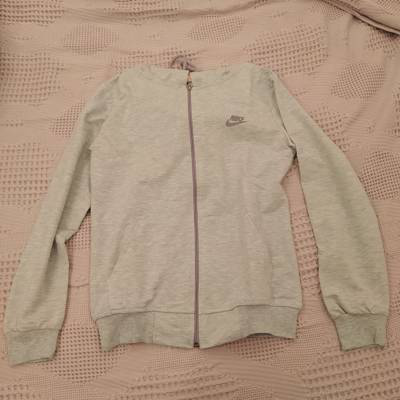

In [230]:
#They could be either in train, test or validation directory because of merging the dataframe and poor choice of defining "file_id" column

PATH = f'../../../clothing-dataset-small/test'
FILE = X_test_full.iloc[50]['file_id']

FULL_PATH = f"{PATH}/{FILE}"

img = load_img(FULL_PATH, target_size=(400,400))
img

In [231]:
f"The ground truth for this picture is: {X_test_full.iloc[50]['label']}."

'The ground truth for this picture is: 2.'

So, it is a longsleeve, but our prediction set says it could be a longsleeve, outwear or shirt. Maybe the confusion is due to the colors. We see that zipper has the same color as the surrounding blanket. Note also that `score` methods are less informative in comparison to APS.

Let's load a random shirt and outwear.

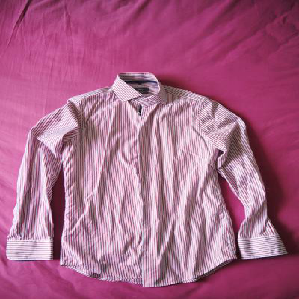

In [232]:
SHIRT_PATH = f'../../../clothing-dataset-small/train/shirt/04d651a3-4c1b-410c-9b92-d046fe6a33ba.jpg'

img = load_img(SHIRT_PATH, target_size=(299,299))
img

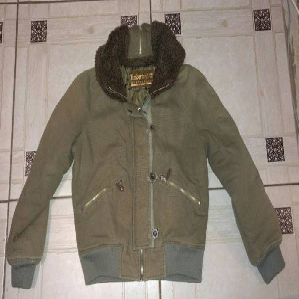

In [233]:
OUTWEAR_PATH = f'../../../clothing-dataset-small/train/outwear/ff231d91-0ff6-4485-98e7-a05c26f09fec.jpg'

img = load_img(OUTWEAR_PATH, target_size=(299,299))
img

Our dataset contsists of lot of 'unironed' shirts and that might be the feature the model probably picked up and associated with "shirts". A blind guess.

For "why the outwear" I don't have any imagination, apart for sleeves that look kind-of the same. Let's check does the confusion matrix reveals the most confusing classes 'longsleeve' and 'shirt'. 

In [234]:
for s in sets_of_size_three:
    st = f"The ground truth for this picture is: {X_test_full.iloc[s]['label']}."
    print(st)

The ground truth for this picture is: 2.
The ground truth for this picture is: 5.
The ground truth for this picture is: 5.
The ground truth for this picture is: 2.
The ground truth for this picture is: 5.
The ground truth for this picture is: 2.
The ground truth for this picture is: 2.
The ground truth for this picture is: 5.
The ground truth for this picture is: 2.


Even the score method doesn't contradict uncertainty in particular classes (note that some instances could be easier for particular classes!). We've got that average coverage is 95.15%. Let's check the coverage per class, and I'm shamelessly copy/pasting code from "Introduction to Conformal Prediction" by Christoph Molnar here (sorry bro, my intentions are good).

In [235]:
def class_wise_performance(y_new, y_set, classes):
    df = pd.DataFrame()

    # Loop through the classes
    for i in range(len(classes)):
    
        # Calculate the coverage and set size for the current class
        ynew = y_new.values[y_new.values == i]
        yscore = y_set[y_new.values == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)

        # Create a new dataframe with the calculated values
        temp_df = pd.DataFrame({
            "class": [classes[i]],
            "coverage": [cov],
            "avg. set size": [size]
        }, index=[i])

        # Concatenate the new dataframe with the existing one
        df = pd.concat([df, temp_df])

    return df


In [236]:
class_names = list(class_indices.keys())

In [237]:
class_coverage_score = class_wise_performance(y_test, y_set, class_names)

In [238]:
print(class_coverage_score)

        class  coverage  avg. set size
0       dress  0.904762       1.190476
1         hat  1.000000       1.045455
2  longsleeve  0.929412       1.341176
3     outwear  0.888889       1.138889
4       pants  0.963415       1.012195
5       shirt  0.882353       1.372549
6       shoes  1.000000       1.022727
7      shorts  0.973684       1.157895
8       skirt  0.900000       1.200000
9     t-shirt  0.992701       1.043796


See where the poor coverage per class is the average set size is also a bit higher, and as I've mentioned we want them to be equally balanced in terms of coverage. 

## Model + `MapieClassifier(method="cumulated_score")` (APS method)

To use Adaptive Prediction Sets method via `MapieClassifier` you have to set `method="cumulated_score"` in `MapieClassifier` object, and lately in it's `predict` method you should set `include_last_label="randomized"` for the best results in terms of coverage per class. This time, it is up to you to find out why. ;)

In [239]:
mapie_score_aps = MapieClassifier(estimator=cls,
                                  cv='prefit',
                                  method='cumulated_score',
                                  random_state=1)
mapie_score_aps.fit(X_calib_aps, y_calib_aps)

MapieClassifier(cv='prefit',
                estimator=<catboost.core.CatBoostClassifier object at 0x7f80988274f0>,
                method='cumulated_score', random_state=1)

In [240]:
y_pred, y_set = mapie_score_aps.predict(X_test,
                                    alpha=0.05,
                                    include_last_label="randomized")

y_set = np.squeeze(y_set)

In [241]:
cov_aps = classification_coverage_score(y_test, y_set)
setsize_aps = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov_aps))
print("Avg. set size: {:.2f}".format(setsize_aps))

Coverage: 95.87%
Avg. set size: 1.62


Let's test the coverage per class:

In [242]:
class_coverage_aps = class_wise_performance(y_test, y_set, class_names)

In [243]:
print(class_coverage_aps)

        class  coverage  avg. set size
0       dress  0.976190       2.000000
1         hat  1.000000       2.363636
2  longsleeve  0.917647       1.905882
3     outwear  0.972222       2.111111
4       pants  0.975610       1.268293
5       shirt  0.980392       2.156863
6       shoes  0.931818       1.000000
7      shorts  0.973684       1.578947
8       skirt  0.950000       2.600000
9     t-shirt  0.956204       1.145985


In [244]:
#Here is a poor man's side-by-side comparison:
pd.concat([pd.DataFrame({'method': ["APS"] * len(class_coverage_aps)}), class_coverage_aps,
           pd.DataFrame({'|': ["|"] * len(class_coverage_aps)}),
           pd.DataFrame({'method': ["score"] * len(class_coverage_aps)}),
           class_coverage_score], axis=1)

,method,class,coverage,avg. set size,|,method,class,coverage,avg. set size
0,APS,dress,0.976190,2.000000,|,score,dress,0.904762,1.190476
1,APS,hat,1.000000,2.363636,|,score,hat,1.000000,1.045455
2,APS,longsleeve,0.917647,1.905882,|,score,longsleeve,0.929412,1.341176
3,APS,outwear,0.972222,2.111111,|,score,outwear,0.888889,1.138889
4,APS,pants,0.975610,1.268293,|,score,pants,0.963415,1.012195
5,APS,shirt,0.980392,2.156863,|,score,shirt,0.882353,1.372549
6,APS,shoes,0.931818,1.000000,|,score,shoes,1.000000,1.022727
7,APS,shorts,0.973684,1.578947,|,score,shorts,0.973684,1.157895
8,APS,skirt,0.950000,2.600000,|,score,skirt,0.900000,1.200000
9,APS,t-shirt,0.956204,1.145985,|,score,t-shirt,0.992701,1.043796


Again, APS gives you opportunity to have approximate conditional coverage (~ `(1-alpha)` per class). That is why this table will serve me as a reference point for testing the hypothesis if using multiple `VennABERS` improves the conditional coverage for a given APS or not.

---

About the empty sets taken from the MAPIE documentation:

*"When the class coverage level is not large enough, the prediction sets can be empty. This happens because the model is uncertain at the border between two labels. These so-called null regions disappear for larger coverage levels."*

In [245]:
true_counts = np.sum(y_set, axis=1)

#APS could produce empty sets
empty_sets = np.where(true_counts == 0)[0] 

# Find rows with more than one True value
sets_of_size_two = np.where(true_counts == 2)[0]
sets_of_size_three = np.where(true_counts == 3)[0]
sets_with_more_than_three = np.where(true_counts > 3)[0]

In [246]:
len(empty_sets), len(sets_of_size_two), len(sets_of_size_three), len(sets_with_more_than_three)

(16, 100, 38, 46)

I'm more interested in those 16 empty sets to check the ambiguity between classes.

In [247]:
empty_sets

array([  2,  98, 120, 122, 149, 196, 219, 250, 335, 371, 393, 422, 441,
       443, 487, 538])

In [248]:
true_indices = np.where(y_set[98])[0]
true_indices

array([], dtype=int64)

Let's collect the classes and check if they are according to the documentation represent ones with smaller coverage.

In [249]:
classes_empty_sets = []
for element in empty_sets:
    es_label = X_test_full.iloc[element]['label']
    classes_empty_sets.append(es_label)

In [250]:
#They are consisting of these unique classes
set(classes_empty_sets)

{0, 2, 4, 6, 9}

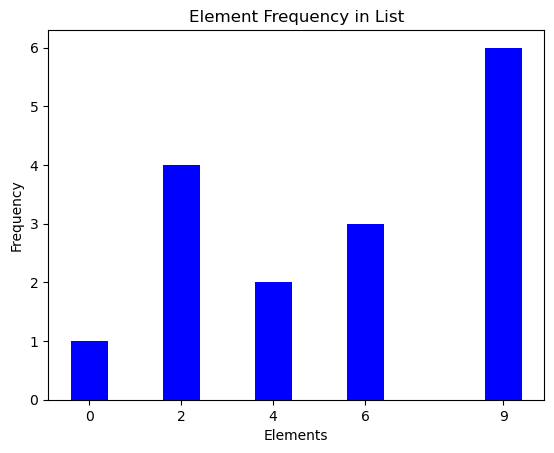

In [251]:
#Let's calculate the frequency of each class
element_frequency = Counter(classes_empty_sets)
frequency_dict = {}

for element, frequency in element_frequency.items():
    frequency_dict[element] = frequency

# Extract elements and frequencies for plotting
elements = list(element_frequency.keys())
frequencies = list(element_frequency.values())

# Plotting the bar chart
plt.bar(elements, frequencies, color='blue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.xticks(list(set(classes_empty_sets)))
plt.title('Element Frequency in List')
plt.show()

The frequency list (closely) depicts the underlying distribution of classes in the overal and test dataset, and overall (apart from one 'dress' and two 'pants') it should mimic the class coverage:

In [252]:
class_coverage_aps.sort_values(by='coverage')

,class,coverage,avg. set size
2,longsleeve,0.917647,1.905882
6,shoes,0.931818,1.000000
8,skirt,0.950000,2.600000
9,t-shirt,0.956204,1.145985
3,outwear,0.972222,2.111111
7,shorts,0.973684,1.578947
4,pants,0.975610,1.268293
0,dress,0.976190,2.000000
5,shirt,0.980392,2.156863
1,hat,1.000000,2.363636


Let's check all those images.

In [253]:
empty_sets

array([  2,  98, 120, 122, 149, 196, 219, 250, 335, 371, 393, 422, 441,
       443, 487, 538])

In [254]:
empty_set_file_ids = []
empty_set_labels = []

for idx in empty_sets:
    file_id = X_test_full.iloc[idx]['file_id']
    label = X_test_full.iloc[idx]['label']
    
    empty_set_file_ids.append(file_id)
    empty_set_labels.append(label)
    

In [255]:
empty_set_file_ids

['shoes/49d3d0c4-851c-4571-9bc2-783156945a67.jpg',
 'longsleeve/24c1d77c-5ce2-4b5c-be2c-1aeccae3efe2.jpg',
 'dress/9764558f-a55d-4909-865a-b2967debafef.jpg',
 'pants/e902f123-8651-4b58-ba92-be8bd9663cfc.jpg',
 'longsleeve/e4a2665e-3479-4890-aec0-fd531c555c97.jpg',
 'pants/c5924c48-00cc-43bd-b8a3-300a1ae7551f.jpg',
 'longsleeve/bc96eb47-531d-410f-bcae-dab5ec60db66.jpg',
 'shoes/802451d1-e9e5-411f-acf7-5d9fe2f0348e.jpg',
 't-shirt/c65f3500-c97e-4d0e-8154-d3db78f3b8e8.jpg',
 't-shirt/10053308-100b-4249-a638-ec23b4df4138.jpg',
 't-shirt/39262aa5-eb53-4d26-879a-c0bdb560d7fe.jpg',
 't-shirt/c5371dda-ab7d-4bfc-9b5b-275c579e3f94.jpg',
 't-shirt/996ee77c-3ed1-4630-9838-5d141ff18536.jpg',
 'longsleeve/d898c146-ef98-42ef-ad34-062d0a089673.jpg',
 't-shirt/31b48259-982e-49b2-8bfe-115136532045.jpg',
 'shoes/e6230ea8-cef3-4046-bccf-6d78135ad658.jpg']

Next time I should be more careful when defining values for columns and provide more thoughtful paths I guess... 

In [256]:
#Example 

In [257]:
# Define the command
command = 'find ../../../ -type f -name "9764558f-a55d-4909-865a-b2967debafef.jpg"'

# Execute the command using subprocess
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

result.stdout

'../../../clothing-dataset-small/train/dress/9764558f-a55d-4909-865a-b2967debafef.jpg\n'

In [258]:
# Extract everything after the last '/'
extracted_filenames = [path.split('/')[-1] for path in empty_set_file_ids]
extracted_filenames

['49d3d0c4-851c-4571-9bc2-783156945a67.jpg',
 '24c1d77c-5ce2-4b5c-be2c-1aeccae3efe2.jpg',
 '9764558f-a55d-4909-865a-b2967debafef.jpg',
 'e902f123-8651-4b58-ba92-be8bd9663cfc.jpg',
 'e4a2665e-3479-4890-aec0-fd531c555c97.jpg',
 'c5924c48-00cc-43bd-b8a3-300a1ae7551f.jpg',
 'bc96eb47-531d-410f-bcae-dab5ec60db66.jpg',
 '802451d1-e9e5-411f-acf7-5d9fe2f0348e.jpg',
 'c65f3500-c97e-4d0e-8154-d3db78f3b8e8.jpg',
 '10053308-100b-4249-a638-ec23b4df4138.jpg',
 '39262aa5-eb53-4d26-879a-c0bdb560d7fe.jpg',
 'c5371dda-ab7d-4bfc-9b5b-275c579e3f94.jpg',
 '996ee77c-3ed1-4630-9838-5d141ff18536.jpg',
 'd898c146-ef98-42ef-ad34-062d0a089673.jpg',
 '31b48259-982e-49b2-8bfe-115136532045.jpg',
 'e6230ea8-cef3-4046-bccf-6d78135ad658.jpg']

In [259]:
#Implementation

In [260]:
fuller_paths = []

for path in extracted_filenames:
    command = f'find ../../../ -type f -name "{path}"'
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    fuller_paths.append(result.stdout.strip()) #The strip() method removes leading and trailing whitespace characters, including newline (\n). 

fuller_paths

['../../../clothing-dataset-small/train/shoes/49d3d0c4-851c-4571-9bc2-783156945a67.jpg',
 '../../../clothing-dataset-small/test/longsleeve/24c1d77c-5ce2-4b5c-be2c-1aeccae3efe2.jpg',
 '../../../clothing-dataset-small/train/dress/9764558f-a55d-4909-865a-b2967debafef.jpg',
 '../../../clothing-dataset-small/train/pants/e902f123-8651-4b58-ba92-be8bd9663cfc.jpg',
 '../../../clothing-dataset-small/train/longsleeve/e4a2665e-3479-4890-aec0-fd531c555c97.jpg',
 '../../../clothing-dataset-small/train/pants/c5924c48-00cc-43bd-b8a3-300a1ae7551f.jpg',
 '../../../clothing-dataset-small/train/longsleeve/bc96eb47-531d-410f-bcae-dab5ec60db66.jpg',
 '../../../clothing-dataset-small/train/shoes/802451d1-e9e5-411f-acf7-5d9fe2f0348e.jpg',
 '../../../clothing-dataset-small/train/t-shirt/c65f3500-c97e-4d0e-8154-d3db78f3b8e8.jpg',
 '../../../clothing-dataset-small/train/t-shirt/10053308-100b-4249-a638-ec23b4df4138.jpg',
 '../../../clothing-dataset-small/test/t-shirt/39262aa5-eb53-4d26-879a-c0bdb560d7fe.jpg',
 '

In [261]:
class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [262]:
#Need a quick switch for key, value pairs
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key

In [263]:
get_key_by_value(class_indices, classes_empty_sets[0])

'shoes'

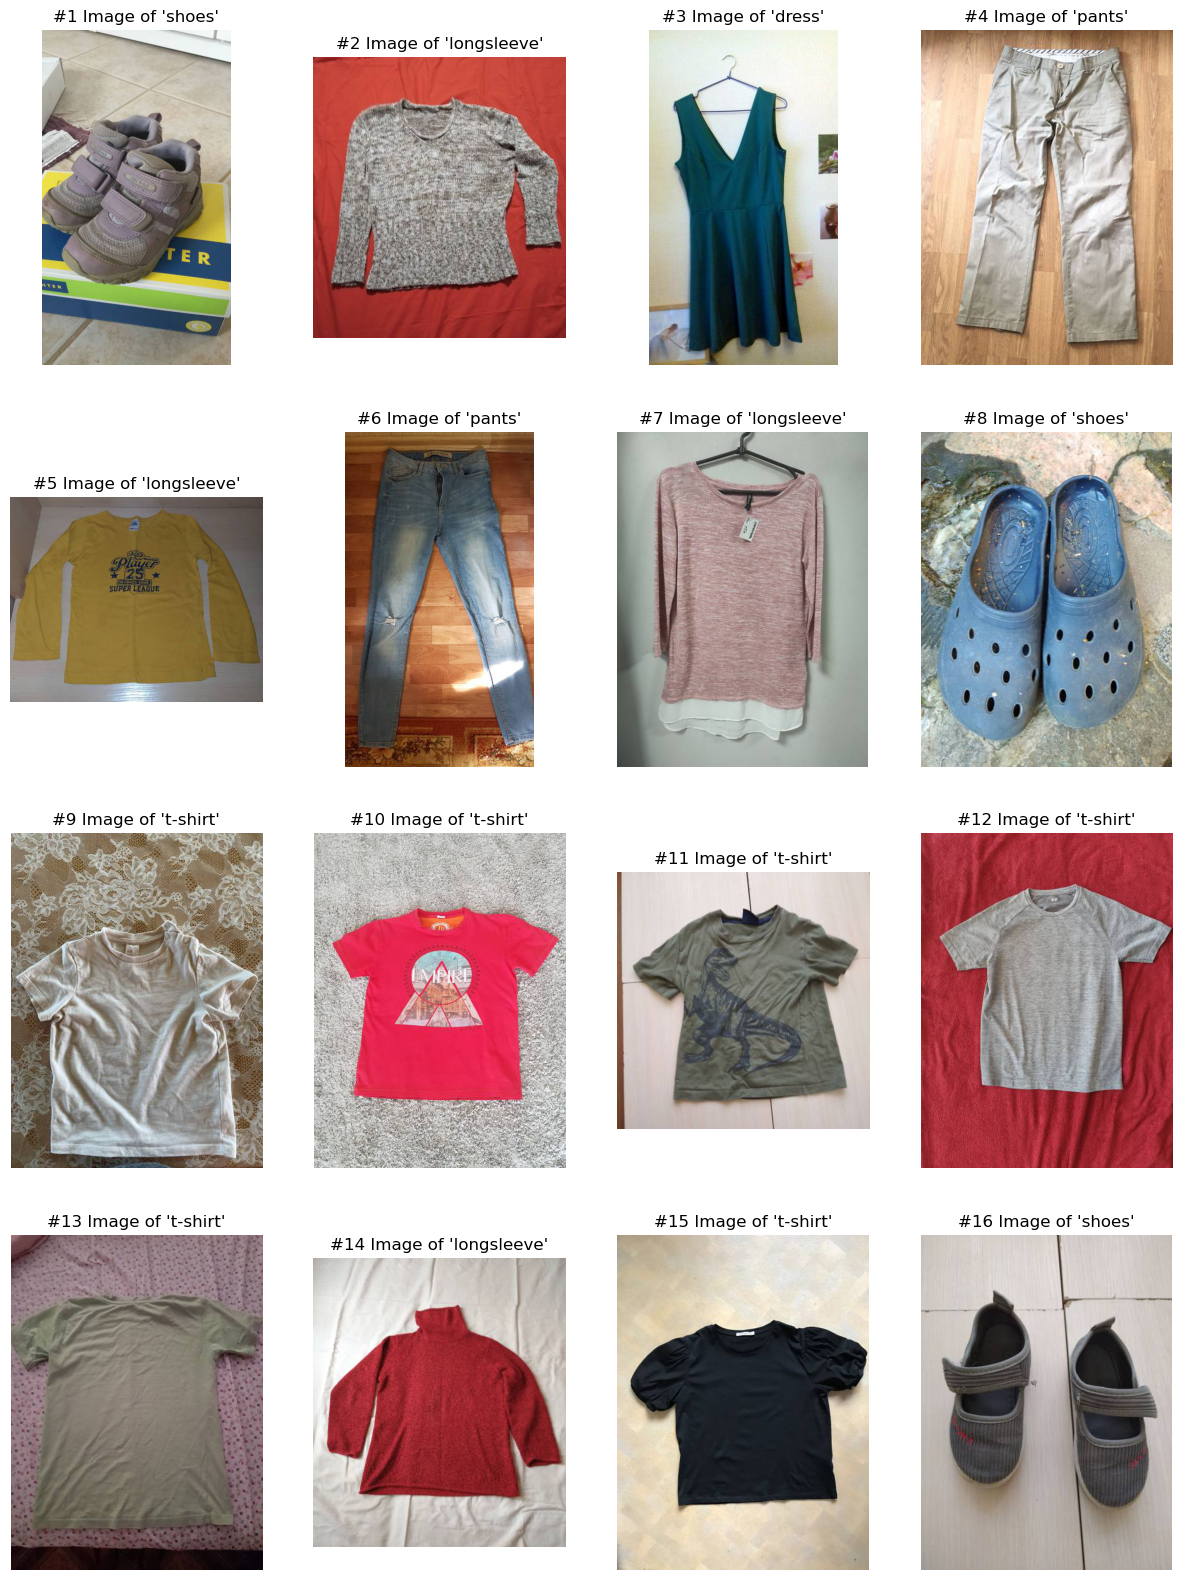

In [264]:
# Load and display all images in rows of 4
num_rows = len(fuller_paths) // 4
fig, axes = plt.subplots(num_rows, 4, figsize=(15, 5*num_rows))

for i, path in enumerate(fuller_paths):
    
    img = load_img(path)
    row_index = i // 4
    col_index = i % 4
    axes[row_index, col_index].imshow(img)
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(f"#{i+1} Image of '{get_key_by_value(class_indices, classes_empty_sets[i])}'")

plt.show()

For some of them the confusion makes sense like e.g. #9, the background is similar to the color of t-shirt, #16 are some wierd looking baby shoes, #2 and #7 are both relatively folded to depict if they have long sleeves or not, and #8 is definetely some wierdass shoes (not even a slipers). Maybe the choice of particular dataset is not well-suited for these kind of "playground investigations" or my creativity detoriated in searching for plausible conclusions. `¯\_(ツ)_/¯`

# VennABERS + APS 

Whilst reading [this Kaggle notebook](https://www.kaggle.com/code/carlmcbrideellis/classifier-calibration-using-venn-abers/notebook), I've realized that there won't be something novel in my idea for calibrating probabilitites before entering the APS (I haven't seen anybody doing the APS part), and the technique is [already extended to multi-class problems](https://proceedings.mlr.press/v60/manokhin17a/manokhin17a.pdf).
Nevertheless, for the sake of applied science and learning some new ideas of manipulating data I will do it anyways. I will also compare the ideas and test to see how bad my approach relative to it's theorethical aspects (and practical implementation). To be honest, I just skimmed the original paper. 

Here is what I had in mind:

Fix the number of calibration points before training a model,

**Iteration #1**: Calibrate the model by "training" `num_classes=10` independent Venn-ABERS predictors such that we input all `X_calib_va` points through the model and capture for each Venn-ABERS predictor it's portion of true class inside `softmax` score obtained as the output of a model. Each Venn Predictor should have it's own array of `predict_proba` in a shape `(1-softmax[class], softmax[class])` or informaly `(1-ground_truth[class], ground_truth[class])`. After preparing the data we then proceed calibrating each Venn-ABERS predictor using `X_calib_va`. Yes we input only those 500 points (not 500 per predictor), and each array should collect it's part from `softmax` score. 

Finally, the output of each calibrator should be modeled as:

$$p_{\text{class}}  = \frac{p_1}{1 - p_0 +p_1}$$

and in particular as an array of those where at each index we would get `p_class` for a given class. At this point I hesitated a bit and thought if we should normalize them by `sum(probabilities)` or using the `softmax`, because in the **Iteration #2** we should use outputs of those Venn-ABERS predictors given `X_calib_abs` to create non-conformity distribution for the MAPIEs APS portion, and finally test everything using `X_test`. I decided to experiment with both of them and see which yield better results. 

(Note also that I didn't knew at that time Cross VennABERS existed, and it yields even better calibration. ;))

### Preprocessing `X_calib_va` for calibrating `VennAbersCalibrator`

In [265]:
preds = cls.predict_proba(X_calib_va)

I will use array indexing `[:, class_index]` to skip loops, and `np.column_stack` to convert them to a shape that `VennAbersCalibrator` expects. Also, convert the arrays to `np.float32`. 

In [266]:
#Example

In [267]:
preds[:4]

array([[1.84761443e-05, 2.01001287e-05, 1.51850425e-04, 8.68718764e-07,
        5.37259514e-06, 1.32358808e-05, 3.28092552e-06, 8.09290729e-07,
        4.52023217e-06, 9.99781486e-01],
       [8.37648247e-01, 5.05431871e-04, 4.52230748e-04, 4.80697494e-04,
        1.50602228e-03, 2.36652971e-04, 2.82501756e-04, 2.55984303e-04,
        1.57732868e-01, 8.99363298e-04],
       [1.29891273e-04, 1.57079092e-03, 1.16495573e-04, 5.90764707e-04,
        6.21085251e-04, 1.11729858e-04, 9.96018801e-01, 2.98015032e-04,
        2.52762017e-04, 2.89664373e-04],
       [1.73149284e-04, 1.14502021e-04, 1.92800788e-04, 2.90514994e-04,
        1.16523518e-03, 7.62516491e-05, 1.83541142e-04, 9.90028873e-01,
        7.66367332e-03, 1.11458735e-04]])

In [268]:
#Class 0 (first four instances)
preds[:,0][:4]

array([1.84761443e-05, 8.37648247e-01, 1.29891273e-04, 1.73149284e-04])

In [269]:
#Every model expects this (1-ground_truth, ground_truth)
(1-preds[:4][:,0], preds[:4][:,0])

(array([0.99998152, 0.16235175, 0.99987011, 0.99982685]),
 array([1.84761443e-05, 8.37648247e-01, 1.29891273e-04, 1.73149284e-04]))

In [270]:
#Let's stack it
np.column_stack((1-preds[:4][:,0], preds[:4][:,0])).astype(np.float32)

array([[9.9998152e-01, 1.8476145e-05],
       [1.6235176e-01, 8.3764827e-01],
       [9.9987012e-01, 1.2989127e-04],
       [9.9982685e-01, 1.7314928e-04]], dtype=float32)

In [271]:
#For collecting the ground-truth labels we will use np.where as filter
y_calib_va.values[:16]

array([9, 8, 6, 7, 5, 9, 9, 3, 6, 9, 2, 9, 3, 1, 9, 0])

In [272]:
#If Class 9 then put 1 there, else put 0 
np.where(y_calib_va.values == 9, 1, 0)[:16]

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [273]:
#Implementation

In [274]:
#These serve us as a calibration points for 10 Venn-ABERS predictors
class_arrays_va = {}
y_labels_va = {}

for class_idx in class_indices.values():
    class_arrays_va[f'class_{class_idx}'] = np.column_stack((1-preds[:, class_idx], preds[:, class_idx])).astype(np.float32)
    y_labels_va[f'class_{class_idx}'] = np.where(y_calib_va.values == class_idx, 1, 0)

In [275]:
#Quickly check if this gives the same result as we've expected for first 4 instances
class_arrays_va['class_0'][:4]

array([[9.9998152e-01, 1.8476145e-05],
       [1.6235176e-01, 8.3764827e-01],
       [9.9987012e-01, 1.2989127e-04],
       [9.9982685e-01, 1.7314928e-04]], dtype=float32)

In [276]:
#Test if np.where is implemented well
y_labels_va['class_9'][:16]

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0])

### Preprocessing `X_calib_aps` for `VennAbersCalibrators` 

Here we are imitating the idea of putting `X_calib_aps` as an input to `model+VennAbersClaibrator` which will get us (near) well-calibrated probabilitites of which we should make distribution of non-conformity scores in our APS part. We don't want APS to be trained soley on uncalibrated model and then use (nearly) well-calibrated model consisting of `model+VennAbersCalibrators` to generate prediction sets for `X_test`.

Since `VennAbersCalibrator` expects two parameters `p_cal` and `p_test` then `p_cal` will use `class_arrays_va` dictionary, and for `p_test` we should use the same logic and preprocess `X_calib_aps`. `X_calib_aps` are probabilities on which we should base our non-conformity distribution and calculating `alpha`. 

Also I've used `VennAbersCalibrator` which will skip the tedious calculation of previously introduced

$$p_{\text{class}}  = \frac{p_1}{1 - p_0 +p_1}$$

After we get those probabilities, a bit of preprocessing should convert them to (calibrated) `softmax` scores which for our final non-conformity distribution for APS. 

In [277]:
preds = cls.predict_proba(X_calib_aps)

#These serve us as a calibration points for APS we need both probabilities and ground truth
class_arrays_va_aps = {}
y_labels_va_aps = {}

for class_idx in class_indices.values():
    class_arrays_va_aps[f'class_{class_idx}'] = np.column_stack((1-preds[:, class_idx], preds[:, class_idx])).astype(np.float32)
    y_labels_va_aps[f'class_{class_idx}'] = np.where(y_calib_aps.values == class_idx, 1, 0)

In [278]:
class_arrays_va_aps.keys()

dict_keys(['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9'])

Let's just test if it works for Class_0 .

In [279]:
#VennCalibrator for Class 0
p_cal  = class_arrays_va['class_0']
y_cal = y_labels_va['class_0']

p_test = class_arrays_va_aps['class_0']

VAC = VennAbersCalibrator()

#These give us p = p0/1-p0+p1 values:
predictions_IVAP = VAC.predict_proba(p_cal=p_cal, y_cal=y_cal, p_test=p_test)[:,1]

In [280]:
#This will serve as a reference point to check if the logic applies when extended to multiple classes
predictions_IVAP[:5]

array([0.00249377, 0.00333333, 0.07142857, 0.0025641 , 0.00254453])

Finally, we should make 10 independent `VennAbersCalibrators` and preprocess the input for the APS (test if they should be normalized and prepare them to look like "calibrated softmax scores").

In [281]:
del p_cal, y_cal, p_test, VAC, predictions_IVAP

In [282]:
predict_proba_aps = {}

for class_idx in class_indices.values():
    #These serve as calibrating points for VennABERS
    p_cal  = class_arrays_va[f'class_{class_idx}']
    y_cal = y_labels_va[f'class_{class_idx}']

    #Don't worry, these just serve us to generate well-calibrated probabilities from VennABERS 
    p_test = class_arrays_va_aps[f'class_{class_idx}']

    VAC = VennAbersCalibrator()

    #These give us p = p0/1-p0+p1 values:
    predictions_IVAP = VAC.predict_proba(p_cal=p_cal, y_cal=y_cal, p_test=p_test)[:,1]
    
    predict_proba_aps[f'class_{class_idx}'] = predictions_IVAP

Let's find a way to concatenate them.

In [283]:
#Example

In [284]:
#Do these look the same as predictions_IVAP[:5]?
a = predict_proba_aps['class_0'][:5]
a

array([0.00249377, 0.00333333, 0.07142857, 0.0025641 , 0.00254453])

In [285]:
b = predict_proba_aps['class_1'][:5]
b

array([0.00234742, 0.00229358, 0.03333333, 0.00240964, 0.0031746 ])

In [286]:
c = predict_proba_aps['class_2'][:5]
c

array([0.0035461 , 0.00471698, 0.01515152, 0.004     , 0.00420168])

In [287]:
#Let's arrange them to look like softmax scores
np.column_stack((a,b,c)).astype(np.float32)

array([[0.00249377, 0.00234742, 0.0035461 ],
       [0.00333333, 0.00229358, 0.00471698],
       [0.07142857, 0.03333334, 0.01515152],
       [0.0025641 , 0.00240964, 0.004     ],
       [0.00254453, 0.0031746 , 0.00420168]], dtype=float32)

In [288]:
del a, b, c

In [289]:
#Implementation

In [290]:
c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9 = predict_proba_aps['class_0'],\
                                                   predict_proba_aps['class_1'],\
                                                   predict_proba_aps['class_2'],\
                                                   predict_proba_aps['class_3'],\
                                                   predict_proba_aps['class_4'],\
                                                   predict_proba_aps['class_5'],\
                                                   predict_proba_aps['class_6'],\
                                                   predict_proba_aps['class_7'],\
                                                   predict_proba_aps['class_8'],\
                                                   predict_proba_aps['class_9']

col_stack = (c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9)

In [291]:
calibrated_softmax_X_calib_aps = np.column_stack(col_stack).astype(np.float32)

In [292]:
calibrated_softmax_X_calib_aps[:4]

array([[0.00249377, 0.00234742, 0.0035461 , 0.00251256, 0.0037037 ,
        0.00242718, 0.0027933 , 0.9583333 , 0.0035461 , 0.00297619],
       [0.00333333, 0.00229358, 0.00471698, 0.00251889, 0.00251256,
        0.00295858, 0.00233645, 0.00240964, 0.00229358, 0.98039216],
       [0.07142857, 0.03333334, 0.01515152, 0.01086957, 0.01886792,
        0.01204819, 0.6666667 , 0.01162791, 0.01886792, 0.01639344],
       [0.0025641 , 0.00240964, 0.004     , 0.00321543, 0.9818182 ,
        0.002849  , 0.00311526, 0.00367647, 0.00239234, 0.00301205]],
      dtype=float32)

In [293]:
#Check if they should be normalized considering first few rows
for i in range(4):
    s = calibrated_softmax_X_calib_aps[i].sum()
    print(s)

0.98467964
1.0057658
0.87525505
1.0090524


At this point I've realized that MAPIE doesn't rely on doing everything manually, so I have one of two options:

- Construct my own APS from scratch which is feasible to some extent, but then it won't be a fair comparison with already trained APS using MAPIE,
- Somehow hack my way into `MapieClassifier.fit()` and `MapieClassifier.predict()` process to get all those goodies by making `FakeClassifier` which emulates some processes as usuall estimator

I will try to implement the later one!

### Preprocessing and calibrating `X_test` using `VennAbersCalibrator` 

We also need to preprocess `X_test` same as `X_calib_aps`. We expext `X_test` to come from (nearly) well-calibrated model, not model without VennABERS.

In [294]:
preds = cls.predict_proba(X_test)

#Calibrated probabilities from VA Calibrators with corresponding ground truths from y_test
class_arrays_va_test = {}
y_labels_va_test = {}

for class_idx in class_indices.values():
    class_arrays_va_test[f'class_{class_idx}'] = np.column_stack((1-preds[:, class_idx], preds[:, class_idx])).astype(np.float32)
    y_labels_va_test[f'class_{class_idx}'] = np.where(y_test.values == class_idx, 1, 0)

In [295]:
#These are output of VA Calibrators and are well-calibrated X_test probabilities that need to be preprocessed to look like softmax scores
predict_proba_aps_test = {}

for class_idx in class_indices.values():
    
    #Same calibation points for VA are needed for both X_calib_aps and X_test due to reproducibility
    p_cal  = class_arrays_va[f'class_{class_idx}']
    y_cal = y_labels_va[f'class_{class_idx}']

    #These are uncalibrated X_test probabilities
    p_test = class_arrays_va_test[f'class_{class_idx}']

    VAC = VennAbersCalibrator()

    #These give us p = p0/1-p0+p1 values:
    predictions_IVAP = VAC.predict_proba(p_cal=p_cal, y_cal=y_cal, p_test=p_test)[:,1]
    
    predict_proba_aps_test[f'class_{class_idx}'] = predictions_IVAP

In [296]:
#Creating calibrated softmax look-a-like scores 
c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9 = predict_proba_aps_test['class_0'],\
                                                   predict_proba_aps_test['class_1'],\
                                                   predict_proba_aps_test['class_2'],\
                                                   predict_proba_aps_test['class_3'],\
                                                   predict_proba_aps_test['class_4'],\
                                                   predict_proba_aps_test['class_5'],\
                                                   predict_proba_aps_test['class_6'],\
                                                   predict_proba_aps_test['class_7'],\
                                                   predict_proba_aps_test['class_8'],\
                                                   predict_proba_aps_test['class_9']

col_stack = (c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9)

In [297]:
calibrated_softmax_X_test = np.column_stack(col_stack).astype(np.float32)

calibrated_softmax_X_test[:5]

array([[0.0042735 , 0.00471698, 0.00480769, 0.00393701, 0.00369004,
        0.003663  , 0.9473684 , 0.00311526, 0.00274725, 0.00413223],
       [0.05555556, 0.01886792, 0.1260606 , 0.8125    , 0.01470588,
        0.02631579, 0.01724138, 0.01639344, 0.05263158, 0.00909091],
       [0.00403226, 0.00680272, 0.00628931, 0.00540541, 0.00510204,
        0.00429185, 0.9411765 , 0.00373134, 0.00303951, 0.00438596],
       [0.00909091, 0.00411523, 0.01538462, 0.00469484, 0.0042735 ,
        0.008     , 0.00404858, 0.00367647, 0.00380228, 0.9444444 ],
       [0.00240964, 0.00223214, 0.00364964, 0.0027248 , 0.98      ,
        0.00255754, 0.00246914, 0.00458716, 0.00221729, 0.00297619]],
      dtype=float32)

In [298]:
calibrated_softmax_X_test[5].sum()

1.0031362

Finally, we need to normalize both `calibrated_softmax_X_calib_aps` and `calibrated_softmax_X_test`.

In [299]:
calibrated_softmax_X_calib_aps_norm = np.exp(calibrated_softmax_X_calib_aps) / np.sum(np.exp(calibrated_softmax_X_calib_aps), axis=1, keepdims=True)
calibrated_softmax_X_test_norm = np.exp(calibrated_softmax_X_test) / np.sum(np.exp(calibrated_softmax_X_test), axis=1, keepdims=True)

### Implementing `FakeClassifier`

Let's check the `MapieClassifier`s [source code](https://github.com/scikit-learn-contrib/MAPIE/blob/master/mapie/classification.py) and see if we can emulate something like that.



For this portion 
```
mapie_score_aps = MapieClassifier(estimator=cls,
                                  cv='prefit',
                                  method='cumulated_score', #I see that cumulated_score will be deprecated soon and we should use 'aps'
```

I think this is interesting

```
if self.cv == "prefit":
            classes = estimator.classes_ #FakeClassifier needs classes_ instance variable
            

if cv == "prefit":
            self.single_estimator_ = estimator
            y_pred_proba = self.single_estimator_.predict_proba(X) #FakeClassifier needs method predict_proba(X)
            y_pred_proba = self._check_proba_normalized(y_pred_proba) #The probabilities should be normalized
            
```

---


and for this part:

```

y_pred, y_set = mapie_score_aps.predict(X = X_test,
                                    alpha=0.05,
                                    include_last_label="randomized")
```

this might be interesting:

```
def predict
---

y_pred = self.single_estimator_.predict(X) #FakeClassifier needs predict method

if cv == "prefit":
            y_pred_proba = self.single_estimator_.predict_proba(X) #and since it will call predict_proba again, we need maybe a generator 
                                                                   #to first yield X_calib_abs and then X_test (both calibrated softmax scores!)

---
```

In [300]:
class FakeClassifier:
    def __init__(self):
        self.classes_ = cls.classes_
        self.predictions_generator = self.predict_proba_generator()

    def predict(self, X):
        #This emulates the process of putting X_test through model + Venn-ABERS calibrators
        return calibrated_softmax_X_test_norm
    
    ###### predict_proba method as generator
    '''
    The generator is implemented because MapieClassifier.fit() method expects this to be done cls.predict_proba(X_calib_aps). Once the MapieClassifier is fitted
    and you call MapieClassifier's predict method it expects the result of cls.predict_proba(X_test). Hence, we need generator to make predict_proba a "state machine".
    '''
    def predict_proba_generator(self):
        # Emulate the process of putting X_calib_aps through model + VennABERS calibrators 
        yield calibrated_softmax_X_calib_aps_norm
        # Emulate the process of putting X_test through model + VennABERS calibrators
        yield calibrated_softmax_X_test_norm

    def predict_proba(self, X):
        return next(self.predictions_generator)
    ########
    
    def fit(self, X):
        #MapieClassifier raises an error if the estimator instance doesn't have fit method implemented
        pass
    
    def __repr__(self):
        #This should be implemented for fun. 
        return "FakestClassifierEver"

fc = FakeClassifier()

:fingers crossed:

In [301]:
mapie_score_aps_calib = MapieClassifier(estimator=fc,
                                  cv='prefit',
                                  method='aps',
                                  random_state=42)

#We use X_calib_aps such that the code doesn't break, but we will get calibrated_softmax_X_calib_aps_norm nevertheless from our FakeClassifier given any input ;)
#y_calib_aps MUST BE there because they represent true labels.
mapie_score_aps_calib.fit(X_calib_aps, y_calib_aps)

MapieClassifier(cv='prefit', estimator=FakestClassifierEver, method='aps',
                random_state=42)

In [302]:
y_pred, y_set = mapie_score_aps_calib.predict(X = X_test,
                                    alpha=0.05,
                                    include_last_label="randomized")

In [303]:
y_set = np.squeeze(y_set)

In [304]:
y_pred.shape, y_set.shape

((557, 10), (557, 10))

In [305]:
cov_aps_calib = classification_coverage_score(y_test, y_set)
setsize_aps_calib = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov_aps_calib))
print("Avg. set size: {:.2f}".format(setsize_aps_calib))

Coverage: 94.25%
Avg. set size: 1.36


In [306]:
class_coverage_aps_calib = class_wise_performance(y_test, y_set, class_names)

In [307]:
print(class_coverage_aps)

        class  coverage  avg. set size
0       dress  0.976190       2.000000
1         hat  1.000000       2.363636
2  longsleeve  0.917647       1.905882
3     outwear  0.972222       2.111111
4       pants  0.975610       1.268293
5       shirt  0.980392       2.156863
6       shoes  0.931818       1.000000
7      shorts  0.973684       1.578947
8       skirt  0.950000       2.600000
9     t-shirt  0.956204       1.145985


In [308]:
print(class_coverage_aps_calib)

        class  coverage  avg. set size
0       dress  0.928571       1.428571
1         hat  1.000000       1.227273
2  longsleeve  0.882353       1.435294
3     outwear  0.888889       1.416667
4       pants  0.975610       1.341463
5       shirt  0.843137       1.490196
6       shoes  1.000000       1.204545
7      shorts  0.973684       1.368421
8       skirt  0.850000       1.700000
9     t-shirt  0.992701       1.277372


In [309]:
#Here is a poor man's side-by-side comparison:
pd.concat([pd.DataFrame({'method': ["APS_Vanilla"] * len(class_coverage_aps)}), class_coverage_aps,
           pd.DataFrame({'|': ["|"] * len(class_coverage_aps)}),
           pd.DataFrame({'method': ["APS_Calibrated"] * len(class_coverage_aps)}),class_coverage_aps_calib
          ], axis=1)

,method,class,coverage,avg. set size,|,method,class,coverage,avg. set size
0,APS_Vanilla,dress,0.976190,2.000000,|,APS_Calibrated,dress,0.928571,1.428571
1,APS_Vanilla,hat,1.000000,2.363636,|,APS_Calibrated,hat,1.000000,1.227273
2,APS_Vanilla,longsleeve,0.917647,1.905882,|,APS_Calibrated,longsleeve,0.882353,1.435294
3,APS_Vanilla,outwear,0.972222,2.111111,|,APS_Calibrated,outwear,0.888889,1.416667
4,APS_Vanilla,pants,0.975610,1.268293,|,APS_Calibrated,pants,0.975610,1.341463
5,APS_Vanilla,shirt,0.980392,2.156863,|,APS_Calibrated,shirt,0.843137,1.490196
6,APS_Vanilla,shoes,0.931818,1.000000,|,APS_Calibrated,shoes,1.000000,1.204545
7,APS_Vanilla,shorts,0.973684,1.578947,|,APS_Calibrated,shorts,0.973684,1.368421
8,APS_Vanilla,skirt,0.950000,2.600000,|,APS_Calibrated,skirt,0.850000,1.700000
9,APS_Vanilla,t-shirt,0.956204,1.145985,|,APS_Calibrated,t-shirt,0.992701,1.277372


Seems like a poor coverage per class, but at least `avg.set size` made complete sense because the model has better calibration using VennABERS Calibrators.

# Inductive VennABERS Calibrator + APS

For multiclass problems `VennAbersCalibrator` (both Inductive and Cross) **uses non-fitted model**, and also it relies on `cal_size` parameter. We will use the previous model with best parameters, and split the data a bit differently. It won't give fair comparison to our idea since it uses different strategy but I will try it anyways. If the coverages look slightly similar then I think either my logic is invalid, or there are some problems in my data pipeline. 

### Train/Test split

In [310]:
size_X_test = 400
size_X_aps_calib = 500
size_X_aps_test_combined = size_X_aps_calib + size_X_test

# X_full will be split via VennAbersCalibrator into proper training + calibration by setting cal_size = 500 ;)
X_full, X_aps_test_combined, y_full, y_aps_test_combined = train_test_split(df, df['label'],\
                                                                            test_size=size_X_aps_test_combined,\
                                                                            random_state=RANDOM_SEED,\
                                                                            stratify=df['label'])

#Finally we will split X_aps_test_combined such that X_aps_calib is used for creating non-conformity scores and X_test is used for final estimation
X_aps_calib, X_test, y_aps_calib, y_test = train_test_split(X_aps_test_combined, y_aps_test_combined,\
                                                            test_size=size_X_test, random_state=RANDOM_SEED,\
                                                            stratify=y_aps_test_combined)


In [311]:
f'We will use {X_full.shape[0]-500} datapoints for "training" IVAC.'

'We will use 2381 datapoints for "training" IVAC.'

In [312]:
X_full = X_full.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_aps_calib = X_aps_calib.drop(['file_id', 'label'], axis=1).reset_index(drop=True)


#Will come in handy when we try to visualize prediction sets
X_test_full = X_test.reset_index(drop=True)
X_test_full = X_test_full[['file_id', 'label']] #To save some RAM ;) 

X_test = X_test.drop(['file_id', 'label'], axis=1).reset_index(drop=True)

y_full = y_full.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_aps_calib = y_aps_calib.reset_index(drop=True)

### Best model obtained via hyperopt

In [313]:
#I'm not sure if this will work the way CatBoost intended but considering that the model is already optimized and starts overfitting slightly at the end I hope the end result
#will be the same. Note that there is no eval_set, and I'm too lazy to look for a workaround. Hope VennABERS will fix if the models uncalibrated scores to some extent. :')
best_params = {'depth': 7,
               'l2_leaf_reg': 1.4488522802077135,
               'learning_rate': 0.13026382468216652}

cls = CatBoostClassifier(**best_params,
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'MultiClass',
                    custom_loss='Accuracy',
                    early_stopping_rounds = 50
                    )
cls.set_params(verbose=500)

In [314]:
size_X_va_calib = 500

va = VennAbersCalibrator(cls, inductive=True, cal_size=size_X_va_calib, random_state=RANDOM_SEED)
va.fit(np.asarray(X_full), np.asarray(y_full))

0:	learn: 0.5882622	total: 90.2ms	remaining: 1m 30s
500:	learn: 0.0010685	total: 36.8s	remaining: 36.7s
999:	learn: 0.0005167	total: 1m 13s	remaining: 0us
0:	learn: 0.6024068	total: 101ms	remaining: 1m 41s
500:	learn: 0.0011996	total: 33.8s	remaining: 33.7s
999:	learn: 0.0005331	total: 1m 5s	remaining: 0us
0:	learn: 0.6066595	total: 94.6ms	remaining: 1m 34s
500:	learn: 0.0009973	total: 36.2s	remaining: 36.1s
999:	learn: 0.0004159	total: 1m 8s	remaining: 0us
0:	learn: 0.5813407	total: 85.8ms	remaining: 1m 25s
500:	learn: 0.0003865	total: 31.3s	remaining: 31.2s
999:	learn: 0.0001894	total: 1m 1s	remaining: 0us
0:	learn: 0.6099381	total: 95.7ms	remaining: 1m 35s
500:	learn: 0.0012562	total: 36.9s	remaining: 36.7s
999:	learn: 0.0005353	total: 1m 9s	remaining: 0us
0:	learn: 0.5775046	total: 69.1ms	remaining: 1m 8s
500:	learn: 0.0003518	total: 30.1s	remaining: 30s
999:	learn: 0.0001794	total: 59s	remaining: 0us
0:	learn: 0.5860495	total: 82.5ms	remaining: 1m 22s
500:	learn: 0.0005267	total: 

### Calibrating predictions for `X_aps_calib` and `X_test` given "prefitted" `VennAbersCalibrator`

Essentially once the `va` is "fitted" it can theoretically calibrate any DataFrame we input. We will then use it to "calibrate" both `X_aps_calib` and `X_test`.

1) The first idea is to do something similar like `FakeClassifier` and extract those calibrated predictions as `pred_aps_calib` and `preds_test` respectively. We will then "fit" the `MapieClassifier` (APS method) using `pred_aps_calib`, and finally test it on our `presd_test`. 

2) BUT, `va` is instance of `VennAbersCalibrator` which we've already fitted. Hence for `MapieClassifier` part we should set the parameters `estimator=va` and `cv='prefit'`. As we've already discussed `MapieClassifier` uses estimators `predict_proba` and `predict` methods. `va`s `predict_proba` method expects for DataFrame objext to be casted as numpy array and we will do so.  

In [315]:
#MAPIE checks if estimator is fitted by testing it using: if not hasattr(est, "classes_")
va.classes_ = va.classes

In [316]:
mapie_score_aps = MapieClassifier(estimator=va,
                                  cv='prefit',
                                  method='aps',
                                  random_state=RANDOM_SEED)
mapie_score_aps.fit(np.array(X_aps_calib), y_aps_calib)

MapieClassifier(cv='prefit',
                estimator=<venn_abers.venn_abers.VennAbersCalibrator object at 0x7f809968bb50>,
                method='aps', random_state=42)

Now we are ready to create prediction sets on the `X_test`. 
**NOTE: It has to be wrapped in `np.array`.**

In [317]:
y_pred, y_set = mapie_score_aps.predict(X = np.array(X_test),
                                    alpha=0.05,
                                    include_last_label="randomized")

In [318]:
y_set.shape

(400, 10, 1)

In [319]:
y_set = np.squeeze(y_set)

In [320]:
y_pred.shape, y_set.shape

((400, 10), (400, 10))

In [321]:
cov_aps_calib_new = classification_coverage_score(y_test, y_set)
setsize_aps_calib_new = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov_aps_calib_new))
print("Avg. set size: {:.2f}".format(setsize_aps_calib_new))

Coverage: 91.50%
Avg. set size: 2.12


Even the promised coverage doesn't hold.

In [322]:
class_coverage_aps_calib_new = class_wise_performance(y_test, y_set, class_names)

In [323]:
print(class_coverage_aps_calib_new)

        class  coverage  avg. set size
0       dress  1.000000       3.225806
1         hat  1.000000       5.812500
2  longsleeve  0.901639       1.803279
3     outwear  0.846154       3.038462
4       pants  0.864407       1.288136
5       shirt  0.944444       2.555556
6       shoes  0.968750       1.656250
7      shorts  0.814815       2.111111
8       skirt  1.000000       4.000000
9     t-shirt  0.918367       1.367347


Since both `coverage` and `avg. set size` are somehow messed up then it is either problem in the way `VennAbersCalibrator` trains the classifier or there is something else I'm missing here. Let's test the accuracy on classifier without using `eval_set`.

In [324]:
best_params = {'depth': 7,
               'l2_leaf_reg': 1.4488522802077135,
               'learning_rate': 0.13026382468216652}

train_pool = Pool(
    data = X_full,
    label = y_full,
)

cls = CatBoostClassifier(**best_params,
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'MultiClass',
                    custom_loss='Accuracy',
                    early_stopping_rounds = 50
                    )
cls.set_params(verbose=200)


cls.fit(train_pool)

0:	learn: 1.8620433	total: 336ms	remaining: 5m 35s
200:	learn: 0.0517194	total: 59.3s	remaining: 3m 55s
400:	learn: 0.0183105	total: 1m 53s	remaining: 2m 49s
600:	learn: 0.0093781	total: 2m 48s	remaining: 1m 51s
800:	learn: 0.0059168	total: 3m 43s	remaining: 55.5s
999:	learn: 0.0041986	total: 4m 37s	remaining: 0us


Let's check the `accuracy_score` on `X_test`.

In [325]:
from sklearn.metrics import accuracy_score

y_pred = cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.935


Maybe the `VennAbersCalibrator` is not in a good fit with `catboost` library. ` ¯\_(ツ)_/¯`. It [works well](https://www.kaggle.com/code/carlmcbrideellis/classifier-calibration-using-venn-abers/notebook) with `xgboost` library.

Let's check the final summary table:

In [330]:
pd.concat([pd.DataFrame({'method': ["APS_Vanilla"] * len(class_coverage_aps)}), class_coverage_aps,
           pd.DataFrame({'|': ["|"] * len(class_coverage_aps)}),
           pd.DataFrame({'method': ["APS_Calibrated (Manual)"] * len(class_coverage_aps)}),class_coverage_aps_calib,
           pd.DataFrame({'|': ["|"] * len(class_coverage_aps)}),
           pd.DataFrame({'method': ["APS_Calibrated (Automatic) "] * len(class_coverage_aps)}), class_coverage_aps_calib_new],
          axis=1)

,method,class,coverage,avg. set size,|,method,class,coverage,avg. set size,|,method,class,coverage,avg. set size
0,APS_Vanilla,dress,0.976190,2.000000,|,APS_Calibrated (Manual),dress,0.928571,1.428571,|,APS_Calibrated (Automatic),dress,1.000000,3.225806
1,APS_Vanilla,hat,1.000000,2.363636,|,APS_Calibrated (Manual),hat,1.000000,1.227273,|,APS_Calibrated (Automatic),hat,1.000000,5.812500
2,APS_Vanilla,longsleeve,0.917647,1.905882,|,APS_Calibrated (Manual),longsleeve,0.882353,1.435294,|,APS_Calibrated (Automatic),longsleeve,0.901639,1.803279
3,APS_Vanilla,outwear,0.972222,2.111111,|,APS_Calibrated (Manual),outwear,0.888889,1.416667,|,APS_Calibrated (Automatic),outwear,0.846154,3.038462
4,APS_Vanilla,pants,0.975610,1.268293,|,APS_Calibrated (Manual),pants,0.975610,1.341463,|,APS_Calibrated (Automatic),pants,0.864407,1.288136
5,APS_Vanilla,shirt,0.980392,2.156863,|,APS_Calibrated (Manual),shirt,0.843137,1.490196,|,APS_Calibrated (Automatic),shirt,0.944444,2.555556
6,APS_Vanilla,shoes,0.931818,1.000000,|,APS_Calibrated (Manual),shoes,1.000000,1.204545,|,APS_Calibrated (Automatic),shoes,0.968750,1.656250
7,APS_Vanilla,shorts,0.973684,1.578947,|,APS_Calibrated (Manual),shorts,0.973684,1.368421,|,APS_Calibrated (Automatic),shorts,0.814815,2.111111
8,APS_Vanilla,skirt,0.950000,2.600000,|,APS_Calibrated (Manual),skirt,0.850000,1.700000,|,APS_Calibrated (Automatic),skirt,1.000000,4.000000
9,APS_Vanilla,t-shirt,0.956204,1.145985,|,APS_Calibrated (Manual),t-shirt,0.992701,1.277372,|,APS_Calibrated (Automatic),t-shirt,0.918367,1.367347


# Conclusions

First of all I can't stress enough that this all started as a purely "intuitive idea" without any theoretical gurantees whatsoever. I can't say whether my implementation is good or not just by looking at this "comparison table", so further fixing and testing is of **much** importance. Yes, it provides very promising average set sizes, which are somewhat expected given that the guarantee for Venn-ABERS predictors holds. I'm at least happy about that, but I do wish that the conditional coverage was better than the 'vanilla APS' method.

Also, keep in mind that I'm literarly abusing the clothing dataset from 'ML Zoomcamp' be it that I've combined features from randomly choosen three pre-trained models and introducing CatBoost on top of it, or having an idea to use it as a playground for testing ideas such as "if probabilities are calibrated then the approximate conditional coverage should be better than default APS". For giving any viable conclusions one should use "proper/industry standard" playground datasets. 

Furthermore you can try "fitting" `Cross VennABERS` and see if it yields even better results. The only difference is that we set number of folds instead of setting `cal_size`.
Also, feel free to create a pull request if you think something could be fixed to make the whole idea work. 


*That's it.
Go away now.*